In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import json

In [2]:
def read_csv(title):
    return pd.read_csv(title, sep=',', encoding='cp1252', engine='python')

def transform_df(df):
    del df['Unnamed: 0']
    df['comments_disabled'] = df['comments_disabled'].transform(lambda x: 0 if x=='False' else 1)
    df['ratings_disabled'] = df['ratings_disabled'].transform(lambda x: 0 if x=='False' else 1)
    return df

def get_category(df, file_name):
    categories_dict = {}
    with open(file_name) as file:
        cats = json.load(file)
        for x in cats['items']:
            categories_dict[x['id']] = x['snippet']['title']

    df['category_name'] = df['categoryId'].transform(lambda x: "Unknown" if x=='False' or not x or pd.isna(x) or str(int(float(x))) not in categories_dict else categories_dict[str(int(float(x)))])
    return df

In [3]:
US80 = read_csv('USdata80.csv')
US90 = read_csv('USdata90.csv')
US95 = read_csv('USdata95.csv')
GB80 = read_csv('GBdata80.csv')
GB90 = read_csv('GBdata90.csv')
GB95 = read_csv('GBdata95.csv')

primal_gb = [GB80, GB90, GB95]
primal_us = [US80, US90, US95]
primal_gb = [get_category(x, 'GB_category_id.json') for x in primal_gb]
primal_us = [get_category(x, 'US_category_id.json') for x in primal_us]

elements = [*primal_gb]
elements.extend(primal_us)
elements = [transform_df(x) for x in elements]

In [4]:
def symbolic_transformer(df, name):
    return df['title'].transform(lambda x: len([y for y in x if y==name]) if x else 0)

def transform_df_symbols_and_title_nuissances(df):
    df['title_length'] = df['title'].transform(lambda x: None if x is None else len(x))
    df['description_length'] = df['description'].transform(lambda x: 0 if not x else len(str(x)))
    df['nr_tags'] = df['tags'].transform(lambda x: 0 if x is None or x=='[None]' else len(x.split('|')))
    df['link_amount'] = df['description'].transform(lambda x: 0 if not x else str(x).count('://'))
    
    df['interpunction_title'] = df['title'].transform(lambda x: len([y for y in x if y in [',', ';', '`', "'", '"', '.', '!', '?', ':']]) if x else 0)
    df['interpunction_exclamation'] = symbolic_transformer(df, '!')
    df['interpunction_question'] = symbolic_transformer(df, '?')
    df['interpunction_dot'] = symbolic_transformer(df, '.')
    df['interpunction_comma'] = symbolic_transformer(df, ',')
    
    df['screams'] = df['title'].transform(lambda x: len([y for y in x if ord(y)>=65 and ord(y)<=90]) if x else 0)
    df['screams_to_normal_proportion'] = df['title'].transform(lambda x: len([y for y in x if ord(y)>=65 and ord(y)<=90])/len(x) if x else 0)
    return df

In [5]:
elements = [transform_df_symbols_and_title_nuissances(x) for x in elements]

In [6]:
def transform_dates(df):
    day_const = (3600*24)
    df['publishedAt_modern'] = df['publishedAt'].transform(lambda x: None if (not x or len(x)<8) else datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
    df['trending_date_modern'] = df['trending_date'].transform(lambda x: None if (not x or len(x)<8) else datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
    
    df['weekday_published'] = df['publishedAt_modern'].transform(lambda x: x.weekday())
    df['time_diff'] = (df['trending_date_modern']-df['publishedAt_modern']).transform(lambda x:x.total_seconds()/(day_const))
    return df

In [7]:
elements = [transform_dates(x) for x in elements]

In [8]:
all_movies = pd.concat(elements)

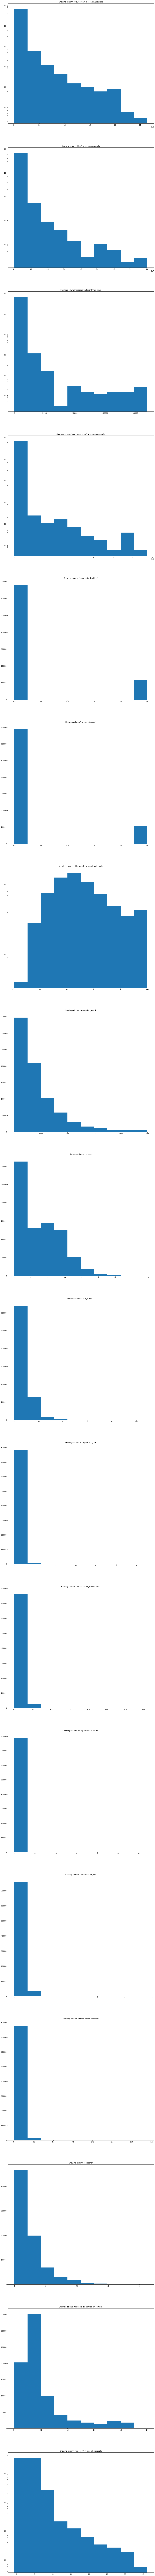

In [10]:
def show_cols_df(df):
    columns_showable = [x for x in df.columns if (df.dtypes[x] == 'float64' or df.dtypes[x] == 'int64') and x != 'categoryId' and x != 'weekday_published']
    
    plotz = len(columns_showable)
    fig, ax = plt.subplots(plotz, 1, figsize=(18,18*plotz))
    for i,x in enumerate(columns_showable):            
        kwargs = {}
        
        title = f'Showing column "{x}"'
        if df.dtypes[x] == 'float64' and x[:3]!='screams'[:3] and x[:3]!='weekday'[:3]:
            kwargs['log'] = True
            title = f'Showing column "{x}" in logarithmic scale'

        ax[i].hist(df[x], **kwargs)
        ax[i].set_title(title)
        
show_cols_df(all_movies)

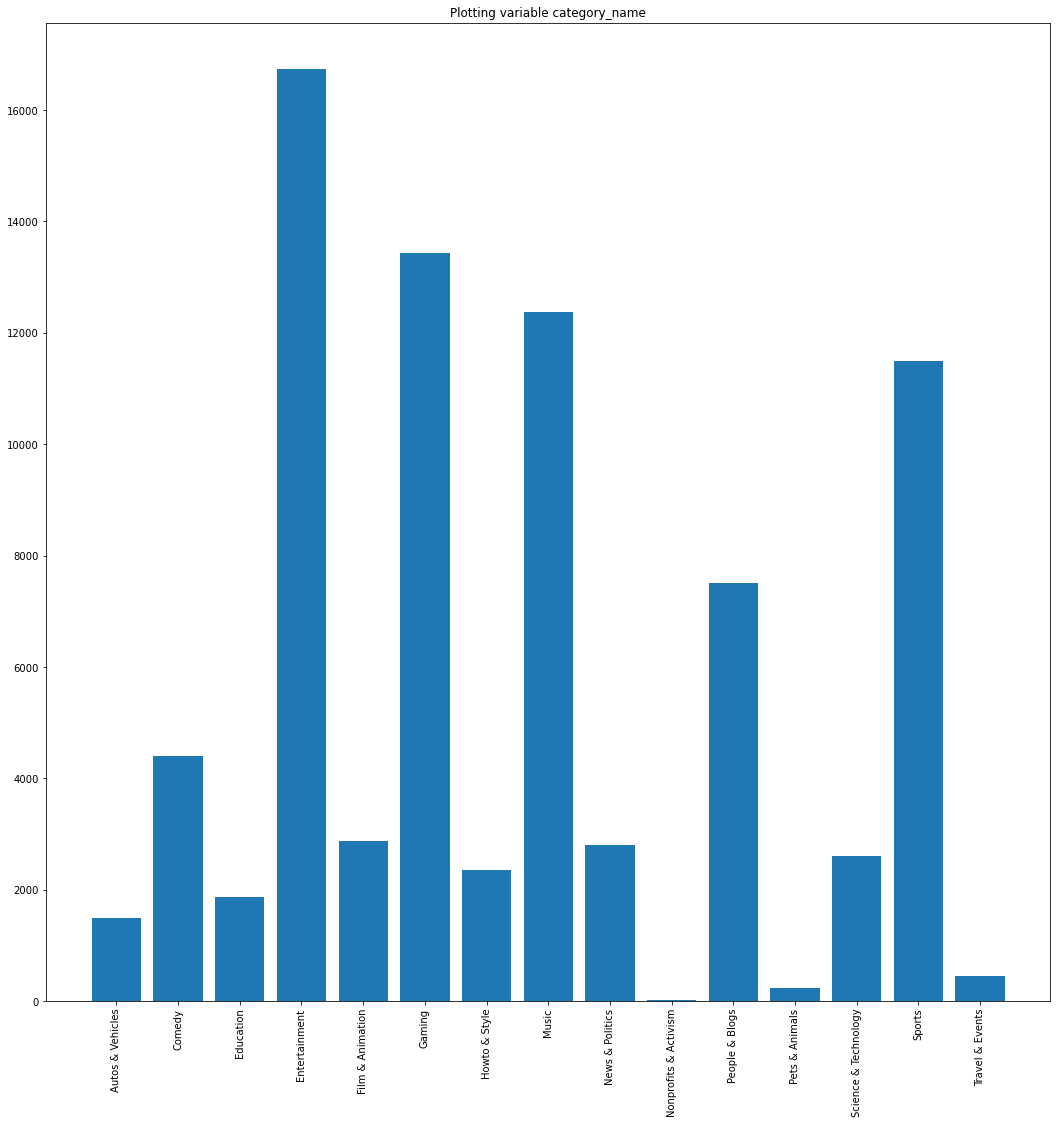

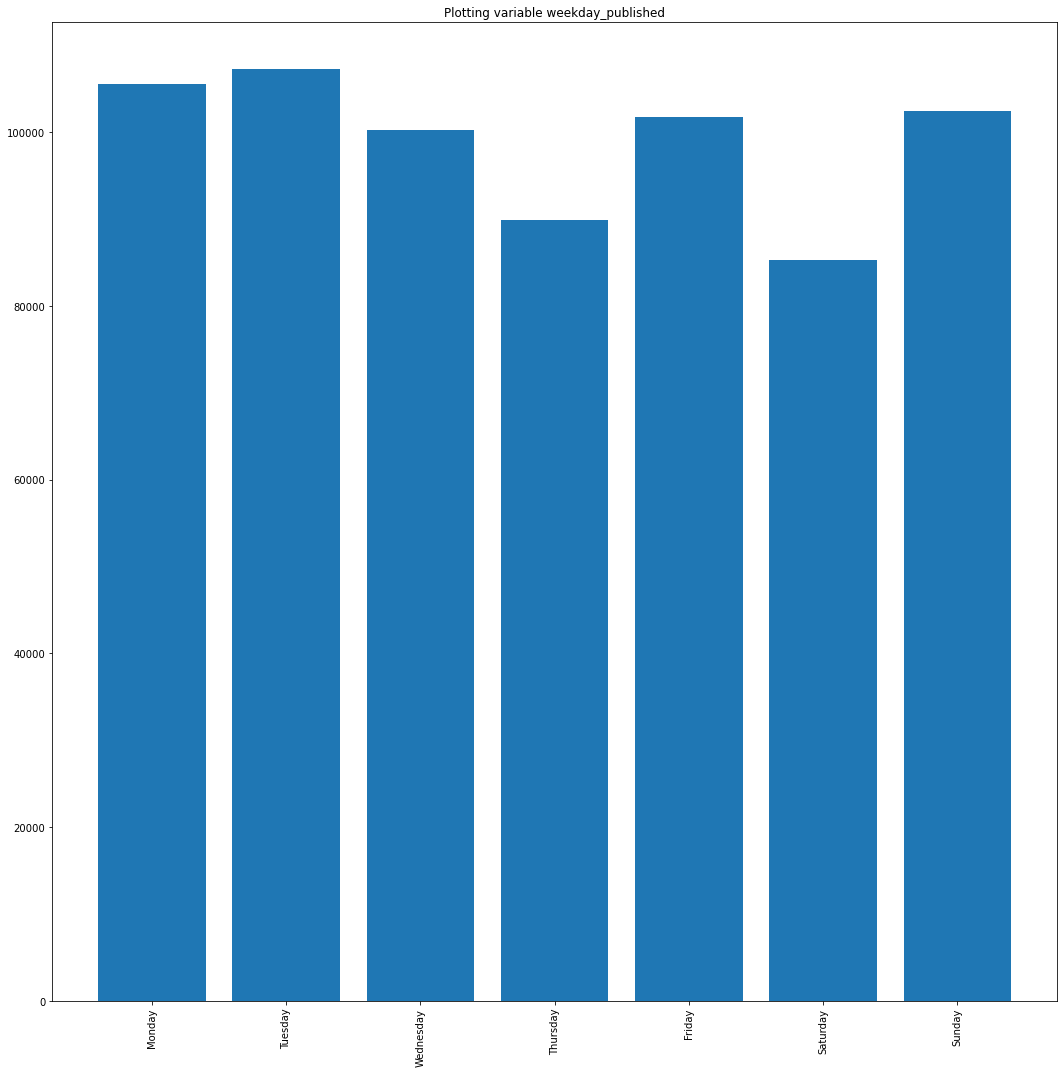

In [11]:
#Tylko pod kategorię
def print_barplot(df, colname, labelz=None):
    dataz = df.groupby([colname])[colname].count()
    if colname == 'category_name':
        dataz = dataz.drop('Unknown')
    fig, ax = plt.subplots(1, 1, figsize=(18,18))
    ax.set_title(f'Plotting variable {colname}')
    
    if labelz!=None:
        dataz.index = labelz
        
    ax.bar(dataz.index, dataz)
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
        
print_barplot(all_movies, 'category_name')
print_barplot(all_movies, 'weekday_published', labelz=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [12]:
all_movies.describe()

,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,title_length,description_length,nr_tags,link_amount,interpunction_title,interpunction_exclamation,interpunction_question,interpunction_dot,interpunction_comma,screams,screams_to_normal_proportion,weekday_published,time_diff
count,6.923160e+05,6.923160e+05,692316.000000,6.923160e+05,793740.000000,793740.000000,692400.000000,793740.000000,793740.000000,793740.000000,793740.000000,793740.000000,793740.000000,793740.000000,793740.000000,793740.000000,793740.000000,692358.000000,692358.000000
mean,2.518539e+06,1.375866e+05,2457.349973,1.127379e+04,0.144901,0.133653,51.128263,831.633627,14.206202,6.160500,1.045926,0.212677,0.229280,0.245045,0.115840,9.771869,0.198974,2.924870,3.256720
std,6.610238e+06,3.956294e+05,11570.277281,8.376140e+04,0.352002,0.340280,20.878854,872.994789,13.017332,7.105225,1.865852,0.574763,1.363527,0.733642,0.437165,10.080591,0.194255,2.025249,2.277152
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.622662
25%,4.350240e+05,1.591500e+04,139.000000,1.139750e+03,0.000000,0.000000,36.000000,207.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.096774,1.000000,1.458206
50%,9.465465e+05,4.442100e+04,527.000000,2.901000e+03,0.000000,0.000000,48.000000,593.000000,13.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.148936,3.000000,3.166435
75%,2.222349e+06,1.184852e+05,1608.000000,7.442000e+03,0.000000,0.000000,64.000000,1148.000000,24.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.227273,5.000000,4.416620
max,2.644074e+08,1.602153e+07,879354.000000,6.738537e+06,1.000000,1.000000,100.000000,4998.000000,79.000000,109.000000,65.000000,18.000000,64.000000,24.000000,17.000000,85.000000,1.000000,6.000000,36.120220


('funny videos', 652)
('season', 668)
('cooking', 670)
('youtube', 671)
('G League', 684)
('memes', 685)
('trending', 693)
('matpat', 701)
('lil durk', 701)
('the', 715)
('hilarious', 726)
('Highlights', 732)
('games', 742)
('yt:cc=on', 743)
('experiment', 749)
('?????????', 750)
('BTS', 754)
('video games', 758)
('education', 759)
('mine craft', 763)
('entertainment', 772)
('basketball', 778)
('highlight', 778)
('prank', 780)
('Funny', 780)
('cartoon', 781)
('??? ??', 786)
('nintendo', 789)
('Pop', 804)
('minecraft hardcore', 810)
('humor', 811)
('laugh', 813)
('boxing', 813)
('viral', 814)
('NFL', 817)
('reacting', 820)
('food', 824)
('Basketball', 830)
('meme', 832)
('espn', 847)
('fortnite battle royale', 859)
('among us', 869)
('nba', 885)
('Music', 894)
('minecraft but', 894)
('marvel', 906)
('parody', 915)
('play', 921)
('live', 928)
('tutorial', 966)
('science', 970)
('interview', 975)
('music video', 977)
('dream', 1025)
('?? ??', 1025)
('diy', 1035)
('soccer', 1064)
('Hip Hop

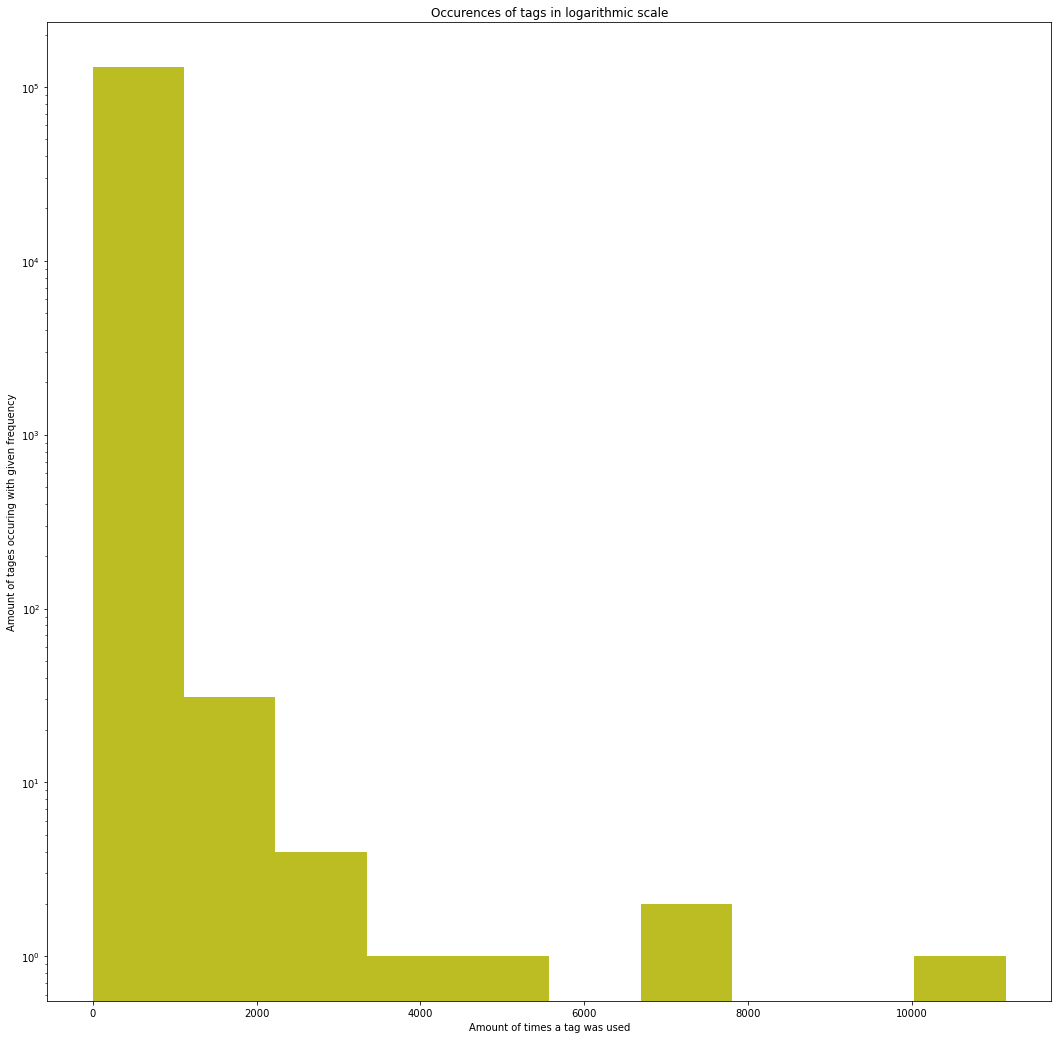

In [13]:
def show_tag_common_and_distribution(df):
    columns_showable = [x for x in df.columns if (df.dtypes[x] == 'float64' or df.dtypes[x] == 'int64') and x != 'categoryId']
    tags = [x for x in US90['tags'] if x != '[None]' and x!=None]
    effective_tags = {}

    for x in tags:
        x = x.split('|')

        for tag in x:
            if tag in effective_tags:
                effective_tags[tag] += 1
            else:
                effective_tags[tag] =1
    
    amounts = [effective_tags[x] for x in effective_tags]
    
    fig, ax = plt.subplots(1, 1, figsize=(18,18))
    for i,x in enumerate(columns_showable):
        ax.hist(amounts, log=True)
        ax.set_title(f'Occurences of tags in logarithmic scale')
        ax.set_xlabel('Amount of times a tag was used')
        ax.set_ylabel('Amount of tages occuring with given frequency')
        
    effective_tags_list = sorted([(x, effective_tags[x]) for x in effective_tags], key = lambda x:x[1])
    _ = [print(x) for x in effective_tags_list[-100:]]
    
show_tag_common_and_distribution(all_movies)

In [14]:
#Teraz: usunięcie duplikatów
post_movies = all_movies.copy()

In [15]:
print(f'Before: {post_movies.shape}')
neo_movies = post_movies.sort_values(by='trending_date_modern').drop_duplicates(subset=['video_id'])
print(f'After : {neo_movies.shape}')

Before: (793740, 32)
After : (31887, 32)


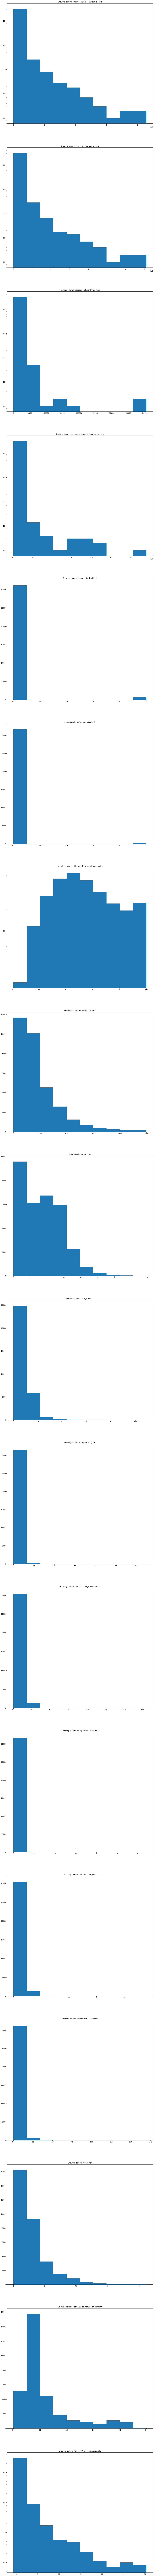

In [16]:
show_cols_df(neo_movies)

('funny videos', 652)
('season', 668)
('cooking', 670)
('youtube', 671)
('G League', 684)
('memes', 685)
('trending', 693)
('matpat', 701)
('lil durk', 701)
('the', 715)
('hilarious', 726)
('Highlights', 732)
('games', 742)
('yt:cc=on', 743)
('experiment', 749)
('?????????', 750)
('BTS', 754)
('video games', 758)
('education', 759)
('mine craft', 763)
('entertainment', 772)
('basketball', 778)
('highlight', 778)
('prank', 780)
('Funny', 780)
('cartoon', 781)
('??? ??', 786)
('nintendo', 789)
('Pop', 804)
('minecraft hardcore', 810)
('humor', 811)
('laugh', 813)
('boxing', 813)
('viral', 814)
('NFL', 817)
('reacting', 820)
('food', 824)
('Basketball', 830)
('meme', 832)
('espn', 847)
('fortnite battle royale', 859)
('among us', 869)
('nba', 885)
('Music', 894)
('minecraft but', 894)
('marvel', 906)
('parody', 915)
('play', 921)
('live', 928)
('tutorial', 966)
('science', 970)
('interview', 975)
('music video', 977)
('dream', 1025)
('?? ??', 1025)
('diy', 1035)
('soccer', 1064)
('Hip Hop

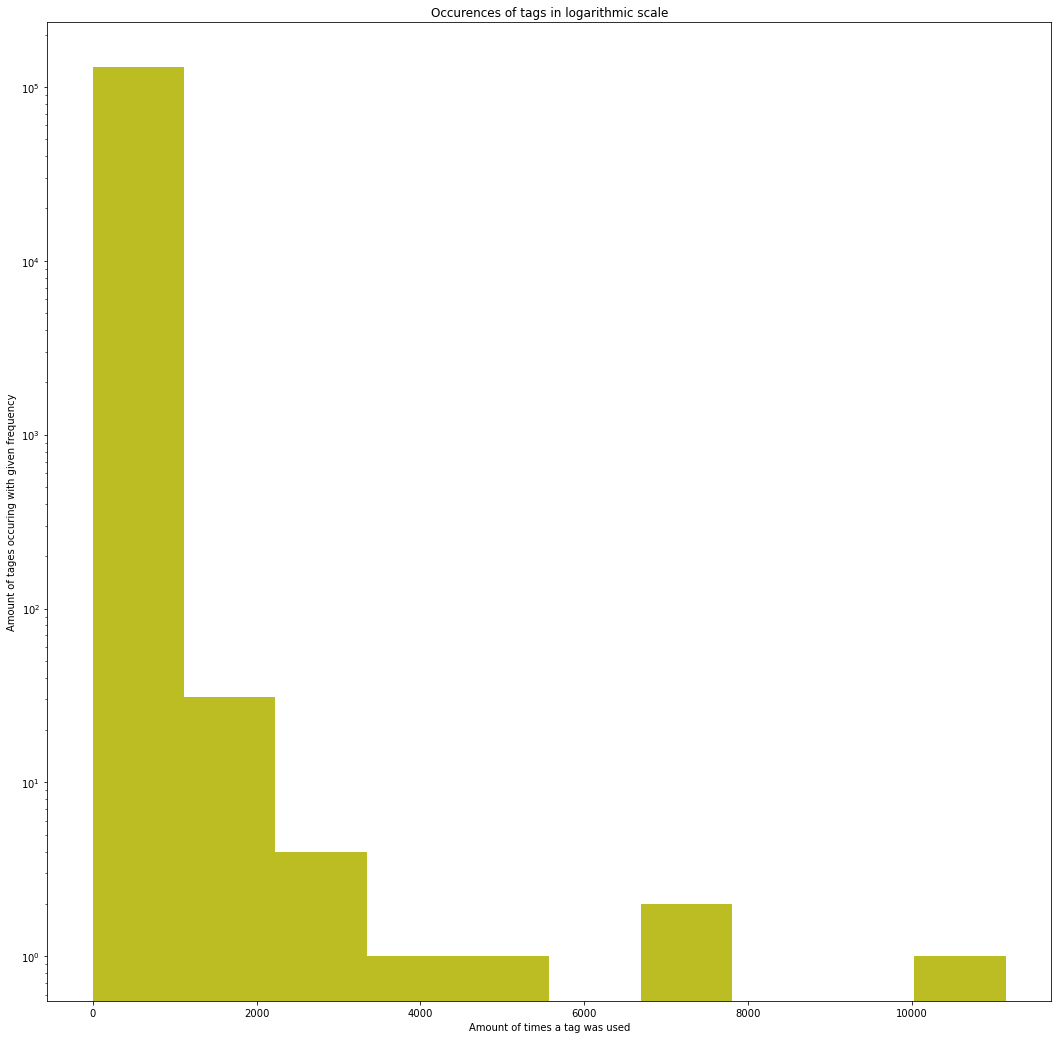

In [17]:
show_tag_common_and_distribution(neo_movies)

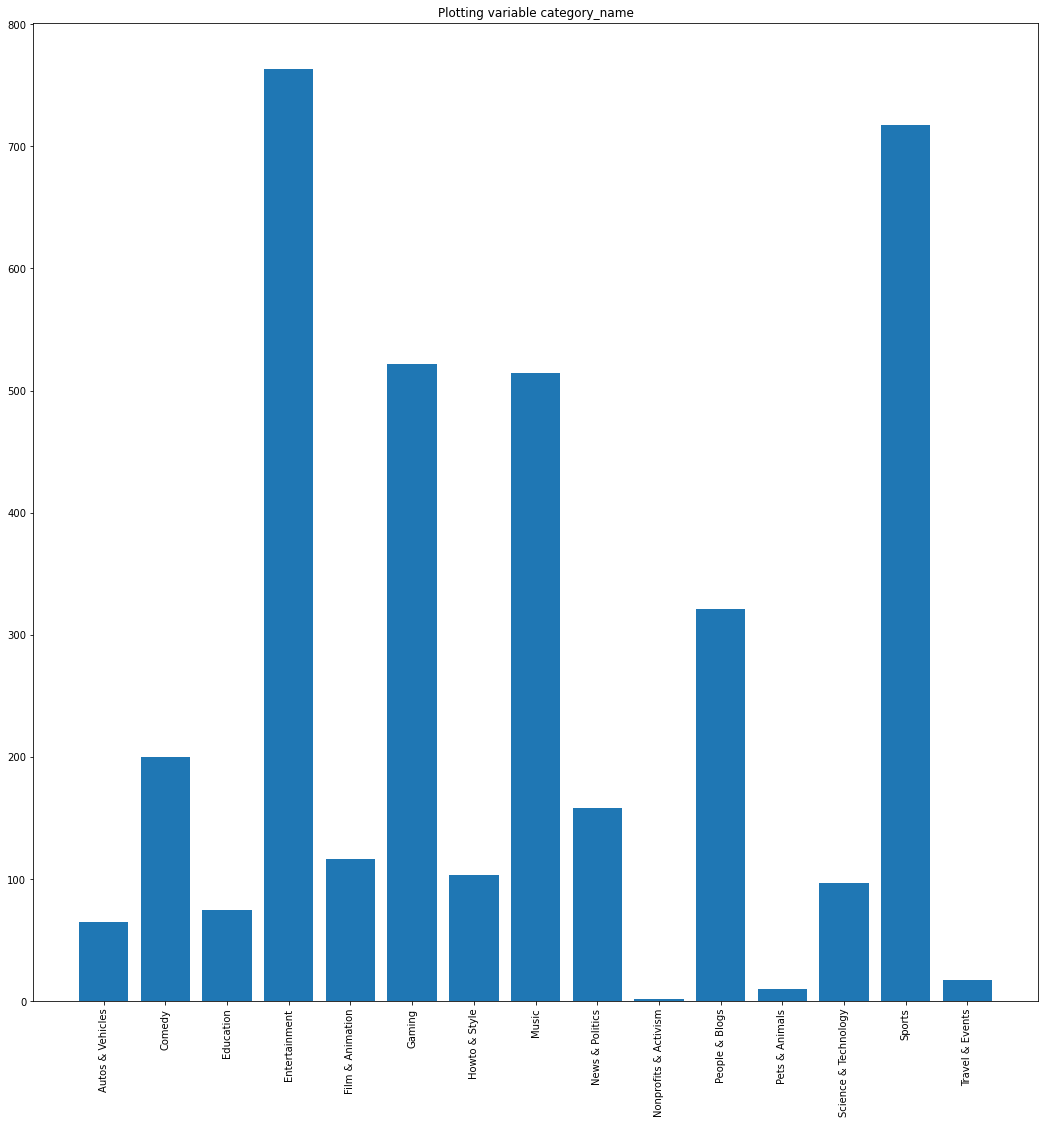

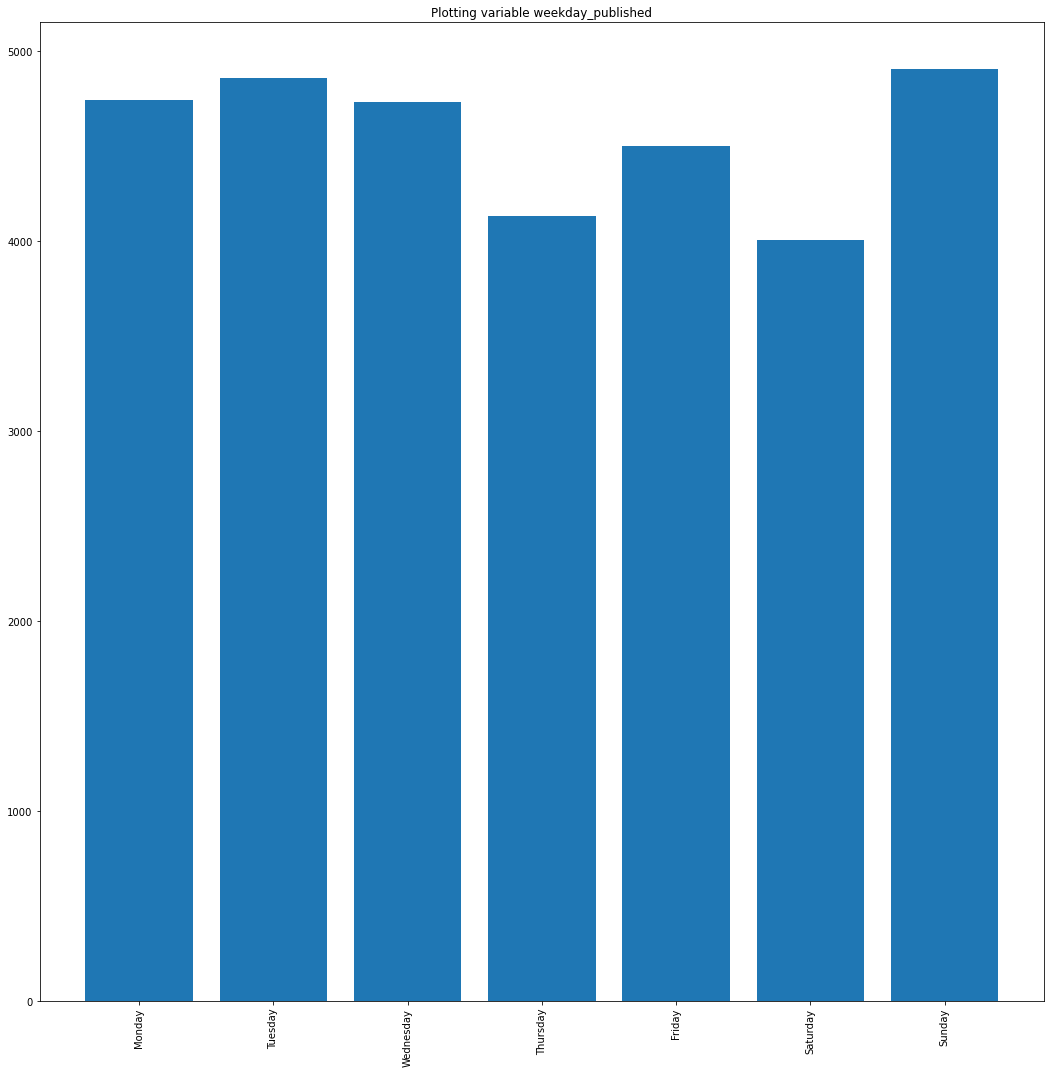

In [18]:
print_barplot(neo_movies, 'category_name')
print_barplot(neo_movies, 'weekday_published', labelz=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [19]:
neo_movies.describe()

,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,title_length,description_length,nr_tags,link_amount,interpunction_title,interpunction_exclamation,interpunction_question,interpunction_dot,interpunction_comma,screams,screams_to_normal_proportion,weekday_published,time_diff
count,3.186900e+04,3.186900e+04,31869.000000,3.186900e+04,31887.000000,31887.000000,31886.000000,31887.00000,31887.000000,31887.000000,31887.000000,31887.000000,31887.000000,31887.000000,31887.000000,31887.000000,31887.000000,31872.000000,31872.000000
mean,1.059993e+06,7.060416e+04,1039.554614,6.003903e+03,0.022454,0.007777,53.025999,906.24154,16.230627,6.868348,1.193025,0.264152,0.255496,0.265218,0.130962,11.617273,0.229610,2.954411,0.841127
std,2.524329e+06,2.013222e+05,4725.114009,4.107027e+04,0.148158,0.087848,21.528495,827.79381,12.484280,6.966181,1.877672,0.636746,1.368885,0.762198,0.461974,10.432715,0.195389,2.030738,1.386673
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.622662
25%,2.376800e+05,8.676000e+03,73.000000,6.750000e+02,0.000000,0.000000,37.000000,357.00000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.121212,1.000000,0.249965
50%,4.693790e+05,2.319900e+04,262.000000,1.703000e+03,0.000000,0.000000,50.000000,677.00000,16.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.160000,3.000000,0.478976
75%,1.029286e+06,5.986800e+04,749.000000,4.248000e+03,0.000000,0.000000,67.000000,1190.00000,25.000000,10.000000,2.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.256410,5.000000,1.136111
max,8.589037e+07,7.110071e+06,405347.000000,3.400291e+06,1.000000,1.000000,100.000000,4998.00000,79.000000,109.000000,65.000000,18.000000,64.000000,24.000000,17.000000,85.000000,1.000000,6.000000,30.333275


In [19]:
## WNIOSKI:
# 1) Dzień opublikowania zdaje się nie być związany z trendingiem
# 2) Na ogół jeśli film trafia do trendin', to trafia tam przez kilka (do kilkunastu) pierwszych dni istnienia
# 3) Część tagów wydaje się być związana z możliwym powodzeniem wideo - m.in. yt:cc=on albo NBA
# 4) Tytuł wskazanych filmów ma rozkład podobny do normalnego, ze średnią rzędu ~50
# 5) Opisy filmów najczęściej zawierają kilka do kilkunastu linków i są na ogół krótsze niż ~2000 znaków
# 6) Interpunkcja tytułów ma podobny rozkład do zwykłego języka angielskiego, jest nieco więcej dużych liter (co 10/co 5 - krótkie tytuły)
# 7) Część wideo to muzyka - z punktu widzenia problemu ona jest raczej nieistotna, można ją odfiltrować tagiem "music" albo title.find("Official~Music")
# 8) Widea w trending wzbudzały przed pojawieniem się w tej zakładce popularność na ogół rzędu ponad 10^5 wyświetleń
# 9) Z danych można usunąć dane, które mają w kategorii Music (? - założenia Francka)
# 10) Niewykluczone, że data publikacji uwzględniała możliwą późniejszą modyfikację, co może fałszować czas publikacja->trendin'

In [20]:
print(neo_movies.columns)

Index(['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle',
       'categoryId', 'trending_date', 'tags', 'view_count', 'likes',
       'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled',
       'ratings_disabled', 'description', 'category_name', 'title_length',
       'description_length', 'nr_tags', 'link_amount', 'interpunction_title',
       'interpunction_exclamation', 'interpunction_question',
       'interpunction_dot', 'interpunction_comma', 'screams',
       'screams_to_normal_proportion', 'publishedAt_modern',
       'trending_date_modern', 'weekday_published', 'time_diff'],
      dtype='object')
